In [60]:
from BCBio import GFF
from Bio import SeqIO
import Bio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def find_codons(seq,codons,frame=1):
    assert len(seq)%3==0
    
    shift=(frame-1)%3    
    loopCount=int(len(seq)/3)
    if shift>0:
        loopCount-=1
        
    if frame>=4:
        codons=[Bio.Seq.Seq(codon).reverse_complement() for codon in codons]
    
    pos_lst=[]
    for i in range(loopCount):
        idx=3*i+shift
        codon=str(seq[idx:idx+3])
        if codon in codons:
            pos_lst.append(idx)
    return pos_lst

In [2]:
gffFilepath = "/data/mitsuki/data/refseq/genomic_gff/GCF_000022125.1_ASM2212v1_genomic.gff"
cds_lst=[]
with open(gffFilepath) as f:
    for rec in GFF.parse(f,target_lines=1):
        assert len(rec.features)==1
        if rec.features[0].type=="CDS":
            cds_lst.append(rec)

In [74]:
def get_df(seqFilepath, cds_lst):
    #read fasta file
    seqRec_lst=[]
    for seqRec in SeqIO.parse(seqFilepath, "fasta"):
        seqRec_lst.append(seqRec)
    print("DONE reading fasta")
    
    #extract each cds reagions
    subSeq_lst=[]
    for cds in cds_lst:
        subSeq=None
        for seqRec in seqRec_lst:
            if cds.id==seqRec.id:
                subSeq=(cds.features[0].extract(seqRec)).seq
        if subSeq is None:
            print("No corresponding id.")
            subSeq_lst.append(None)
        else:
            subSeq_lst.append(subSeq)
    print("DONE extracting cds")
            
    
    #find codons
    dct_lst=[]
    for subSeq in subSeq_lst:
        dct={}
        dct["length"]=len(subSeq)
        if len(subSeq)%3==0 and len(subSeq)>=6:#typical cds
            for frame in range(1,7):
                pos_lst=find_codons(subSeq, codons=["TAA","TAG","TGA"],frame=frame)
                relPos_lst=[pos/len(subSeq) for pos in pos_lst]

                dct["frame{}".format(frame)]=",".join([str(pos) for pos in pos_lst])
                dct["frame{}_rel".format(frame)]=",".join([str(pos) for pos in relPos_lst])
        dct_lst.append(dct)
    print("DONE finding codons")
        
    return pd.DataFrame(dct_lst)

In [72]:
real_df= get_df("/data/mitsuki/out/altorf/genome/fasta/GCF_000022125.1_ASM2212v1_chromosome.fna", cds_lst)
sim_df = get_df("/data/mitsuki/out/altorf/genome/fasta/GCF_000022125.1_ASM2212v1_chromosome_simu03_0.fna", cds_lst)

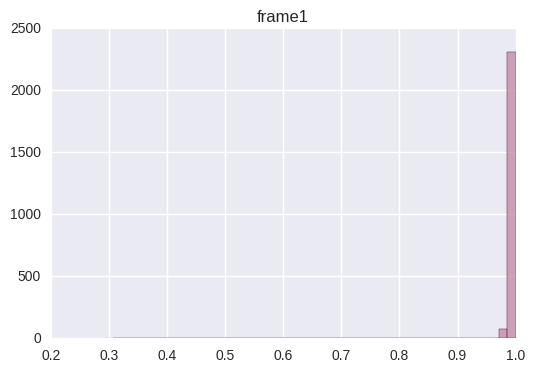

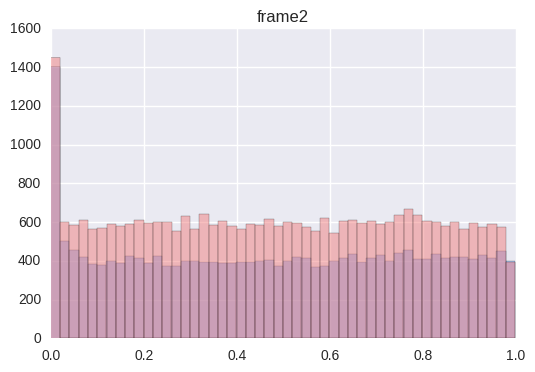

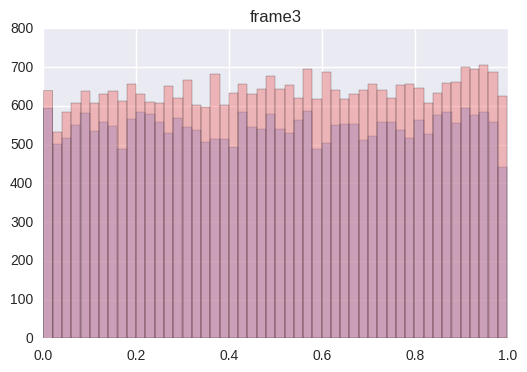

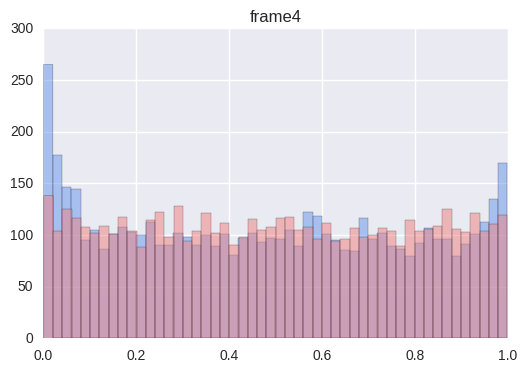

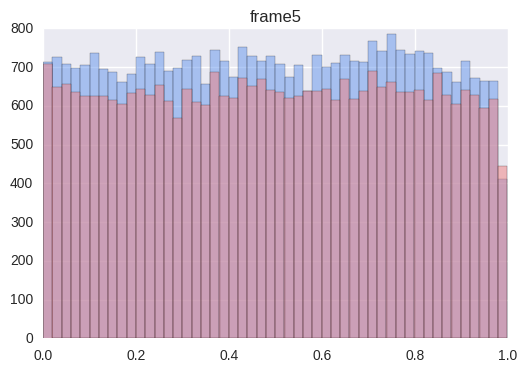

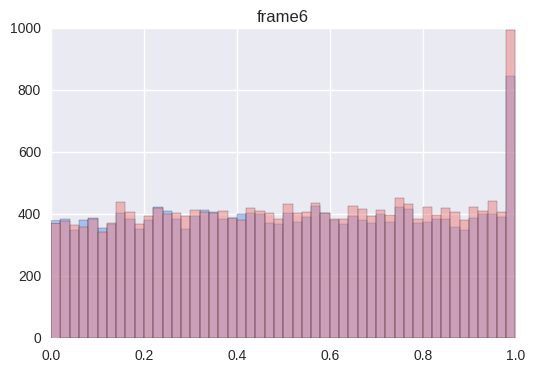

In [83]:
for frame in range(1,7):
    color_lst=["#6495ED","#F08080"]
    for i,df in enumerate((real_df,sim_df)):
        total_lst=[]
        for lst in df["frame{}_rel".format(frame)].dropna():
            if len(lst)>0:
                total_lst+=[float(pos) for pos in lst.split(",")]
        sns.distplot(total_lst, kde=False, rug=False, bins=50,hist_kws={"color":color_lst[i], "alpha":.5})
        plt.title("frame{}".format(frame))
    plt.show()

In [73]:
sim_df.head()

,frame1,frame1_rel,frame2,frame2_rel,frame3,frame3_rel,frame4,frame4_rel,frame5,frame5_rel,frame6,frame6_rel,length
0,222,0.9866666666666667,"1,73,91,205","0.0044444444444444444,0.3244444444444444,0.404...",95,0.4222222222222222,,,"70,94,103,151","0.3111111111111111,0.4177777777777778,0.457777...",77,0.3422222222222222,225
1,1503,0.99800796812749,"1,52,82,91,370,547,598,616,724,988,1045,1069,1...","0.0006640106241699867,0.034528552456839307,0.0...","131,155,191,254,287,329,353,383,440,458,527,56...","0.08698539176626827,0.10292164674634795,0.1268...","105,420,450,954,1326","0.0697211155378486,0.2788844621513944,0.298804...","130,439,481,505,586,628,685,715,721,823,859,94...","0.08632138114209828,0.2915006640106242,0.31938...","146,164,410,470,734,773,797,842,884,923,992,10...","0.09694555112881806,0.10889774236387782,0.2722...",1506
2,324,0.9908256880733946,133,0.40672782874617736,"77,86,128,146","0.23547400611620795,0.26299694189602446,0.3914...",249,0.7614678899082569,"22,52,76,85,145,235","0.0672782874617737,0.15902140672782875,0.23241...","140,158,203,218,272","0.42813455657492355,0.4831804281345566,0.62079...",327
3,1371,0.9978165938864629,"481,520,664,670,772,826,931,1000,1078,1132,128...","0.3500727802037846,0.3784570596797671,0.483260...","5,20,32,200,227,356,422,641,785,818,839,911,10...","0.00363901018922853,0.01455604075691412,0.0232...","306,969,1200","0.22270742358078602,0.7052401746724891,0.87336...","4,73,187,346,379,490,805,862,904,994,1024,1039...","0.002911208151382824,0.05312954876273653,0.136...","596,623,752,1013,1043,1235,1271","0.43377001455604075,0.4534206695778748,0.54730...",1374
4,1152,0.9974025974025974,"1,13,58,130,133,196,295,478,517,541,592,619,65...","0.0008658008658008658,0.011255411255411256,0.0...","44,104,224,269,284,317,338,356,443,647,698,707...","0.0380952380952381,0.09004329004329005,0.19393...","330,438","0.2857142857142857,0.37922077922077924","7,28,43,103,157,355,382,460,547,658,706,751,83...","0.006060606060606061,0.024242424242424242,0.03...","80,170,206,314,524,527,611,728,740,1088,1133","0.06926406926406926,0.1471861471861472,0.17835...",1155


In [16]:
dct_lst=[]
for subSeq in subSeq_lst:
    dct={}
    dct["length"]=len(subSeq)
    if len(subSeq)%3==0 and len(subSeq)>6:
        for frame in range(1,7):
            pos_lst=find_codons(subSeq, codons=["TAA","TAG","TGA"],frame=frame)
            relPos_lst=[pos/len(subSeq) for pos in pos_lst]
            
            dct["frame{}".format(frame)]=",".join([str(pos) for pos in pos_lst])
            dct["frame{}_rel".format(frame)]=",".join([str(pos) for pos in relPos_lst])
            
    dct_lst.append(dct)

In [63]:
df=pd.DataFrame(dct_lst)
df.head(10)

,frame1,frame1_rel,frame2,frame2_rel,frame3,frame3_rel,frame4,frame4_rel,frame5,frame5_rel,frame6,frame6_rel,length
0,222,0.9866666666666667,1,0.0044444444444444444,"98,116","0.43555555555555553,0.5155555555555555",,,"61,70,91,94,103,151,205","0.27111111111111114,0.3111111111111111,0.40444...","11,77,125","0.04888888888888889,0.3422222222222222,0.55555...",225
1,1503,0.99800796812749,"1,337,370,505,526,715,934,988,1069","0.0006640106241699867,0.22377158034528552,0.24...","92,155,251,287,329,353,362,383,458,515,590,728...","0.06108897742363878,0.10292164674634795,0.1666...","9,255,933,1155","0.00597609561752988,0.1693227091633466,0.61952...","91,418,481,628,685,721,823,859,940,949,961,103...","0.06042496679946879,0.2775564409030544,0.31938...","269,410,431,470,536,644,773,797,842,851,884,99...","0.17861885790172644,0.27224435590969454,0.2861...",1506
2,324,0.9908256880733946,"133,145","0.40672782874617736,0.4434250764525994",128,0.39143730886850153,"93,201,210","0.28440366972477066,0.6146788990825688,0.64220...","22,52,235","0.0672782874617737,0.15902140672782875,0.71865...",41,0.12538226299694188,327
3,1371,0.9978165938864629,"4,100,481,490,520,664,673,772,805,955,1024,112...","0.002911208151382824,0.07278020378457059,0.350...","164,296,320,356,422,446,551,599,641,815,839,93...","0.11935953420669577,0.21542940320232898,0.2328...","954,984","0.6943231441048034,0.7161572052401747","73,139,187,277,346,670,862,904,931,994,1000,10...","0.05312954876273653,0.10116448326055313,0.1360...","224,419,473,596,623,893,1235","0.16302765647743814,0.3049490538573508,0.34425...",1374
4,1152,0.9974025974025974,"1,43,196,295,328,382,478,502,652,688,706,754,7...","0.0008658008658008658,0.03722943722943723,0.16...","14,17,140,269,368,443,518,578,641,647,794,1049...","0.012121212121212121,0.01471861471861472,0.121...",246,0.21298701298701297,"7,13,28,58,103,130,136,157,436,451,517,547,592...","0.006060606060606061,0.011255411255411256,0.02...","167,347,404,611,728,740,863,947,1007,1088,1133...","0.1445887445887446,0.30043290043290044,0.34978...",1155
5,2403,0.9987531172069826,"97,298,403,475,574,691,931,1087,1126,1369,1417...","0.04031587697423109,0.12385702410640066,0.1674...","149,158,230,254,326,422,428,470,488,530,545,58...","0.06192851205320033,0.0656691604322527,0.09559...","102,552,2310","0.04239401496259352,0.22942643391521197,0.9600...","46,190,196,220,295,382,409,481,523,604,619,700...","0.019118869492934332,0.07896924355777224,0.081...","29,134,287,338,440,563,599,662,794,896,1094,14...","0.012053200332502078,0.05569409808811305,0.119...",2406
6,2565,0.9988317757009346,"25,31,211,628,712,793,811,1024,1222,1537,1636,...","0.009735202492211837,0.012071651090342679,0.08...","38,98,107,170,206,218,251,335,548,590,608,611,...","0.014797507788161994,0.0381619937694704,0.0416...",,,"76,79,115,136,466,496,616,769,772,832,856,901,...","0.029595015576323987,0.030763239875389408,0.04...","125,167,224,356,437,656,662,689,785,950,1091,1...","0.04867601246105919,0.06503115264797507,0.0872...",2568
7,912,0.9967213114754099,"508,823,904","0.5551912568306011,0.8994535519125683,0.987978...","14,56,260,275,383,458,476,542,644,665,674,746,833","0.015300546448087432,0.06120218579234973,0.284...","492,720","0.5377049180327869,0.7868852459016393","7,28,340,454,574,652,868","0.007650273224043716,0.030601092896174863,0.37...","266,503,611,773","0.2907103825136612,0.5497267759562842,0.667759...",915
8,1401,0.9978632478632479,"1,112,514,520,568,697,739,928,1000,1024,1027,1...","0.0007122507122507123,0.07977207977207977,0.36...","5,35,41,122,140,185,314,389,395,437,506,593,60...","0.0035612535612535613,0.02492877492877493,0.02...","1185,1395","0.844017094017094,0.9935897435897436","4,115,136,328,379,403,454,499,694,850,958,1006...","0.002849002849002849,0.08190883190883191,0.096...","32,62,74,209,230,284,467,485,545,743,788,875,9...","0.022792022792022793,0.04415954415954416,0.052...",1404
9,1248,0.9976019184652278,"1,127,475,811,940,1060,1171","0.00079936051159072

In [66]:
total_lst=[]
for lst in df["frame3_rel"].dropna():
    if len(lst)>0:
        total_lst+=[float(pos) for pos in lst.split(",")]

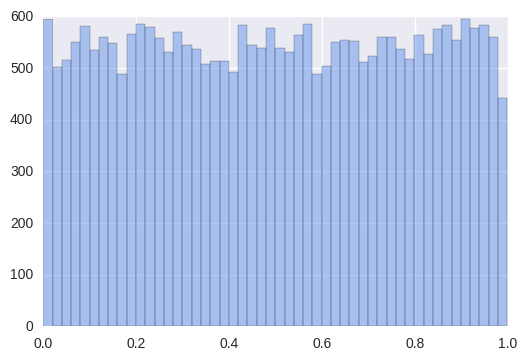

In [67]:
sns.distplot(total_lst, kde=False, rug=False, bins=50,hist_kws={"color":"#6495ED", "alpha":.5})

In [51]:
float(lst)

0.9866666666666667

In [46]:
total_lst

['0.9866666666666667',
 '0.99800796812749',
 '0.9908256880733946',
 '0.9978165938864629',
 '0.9974025974025974',
 '0.9987531172069826',
 '0.9988317757009346',
 '0.9967213114754099',
 '0.9978632478632479',
 '0.9976019184652278',
 '0.9984076433121019',
 '0.9942196531791907',
 '0.9970414201183432',
 '0.9965753424657534',
 '0.9981024667931688',
 '0.9967213114754099',
 '0.9926470588235294',
 '0.9961977186311787',
 '0.9926470588235294',
 '0.9961832061068703',
 '',
 '0.9938650306748467',
 '0.9991489361702127',
 '0.9970238095238095',
 '0.9986754966887417',
 '0.9970501474926253',
 '0.997289972899729',
 '0.9954337899543378',
 '0.9982905982905983',
 '0.9873417721518988',
 '0.9971428571428571',
 '0.9931506849315068',
 '0.996969696969697',
 '0.9955555555555555',
 '0.9846153846153847',
 '0.993006993006993',
 '0.996969696969697',
 '0.9936305732484076',
 '0.9982817869415808',
 '0.9978902953586498',
 '0.9967532467532467',
 '0.9943502824858758',
 '0.9896907216494846',
 '0.9920634920634921',
 '0.99668874

In [40]:
np.nan
lst

nan

In [35]:
type(lst)

float

In [13]:
type(df["frame0_rel"])

pandas.core.series.Series

In [ ]:
print(subSeq)

In [ ]:
find_codons(subSeq,codons=["TAA","TAG","TGA"],frame=6)

In [ ]:
subSeq_lst[2]

In [ ]:
len(cds_lst)

In [ ]:
rec_lst[2].features

In [ ]:
type(rec_lst[0])

In [ ]:
type(rec.features[0].location)

In [ ]:
dir(rec.features[0].location)

In [ ]:
import Bio
help(Bio.SeqFeature)

In [ ]:
seqRec_lst

In [ ]:
feature=rec.features[0]
feature

In [ ]:
subSeq=feature.extract(seqRec_lst[0])

In [ ]:
seqRec=Bio.SeqRecord.SeqRecord("ATGC")

In [ ]:
feature.extract(seqRec)

In [ ]:
seqRec_lst[0].id

In [ ]:
rec_lst[0].id

In [ ]:
type(rec_lst[0])

In [ ]:
rec_lst[0]

In [ ]:
dir(seqRec_lst)

In [ ]:
seqRec_lst[0